In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import load_img, img_to_array



In [10]:
#path of the different folders
train_path = 'chest_xray/train/'
val_path = 'chest_xray/val/'
test_path = 'chest_xray/test/'

In [11]:
#labels
labels=['NORMAL', 'PNEUMONIA']

In [12]:
#setting image size
image_size = 224

In [13]:
def process_data(data_dir, labels, image_size):              #creating the training data
    
    images = []
    for label in labels:
        dir = os.path.join(data_dir,label)

        class_num = labels.index(label)

        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            if image == '.DS_Store':
                continue
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
    return np.array(images)

In [14]:
train = process_data(train_path, labels, image_size)
test = process_data(test_path, labels, image_size)
val = process_data(val_path, labels, image_size)

C:\Users\nujab\AppData\Local\Temp\ipykernel_14256\156260658.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images)


In [15]:
X = []
y = []

for feature, label in train:
    X.append(feature)          #appending all images
    y.append(label)            #appending all labels

for feature, label in val:
    X.append(feature)
    y.append(label)

In [16]:
#Reshaping data in order to feed it into the Neural Network
X = np.array(X).reshape(-1, image_size, image_size, 1)
y = np.array(y)
y = np.expand_dims(y, axis =1)

In [17]:
#Concatenate train and val data

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True)

print('number of images in training set:', X_train.shape[0])
print('number of images in validation set:', X_val.shape[0])


number of images in training set: 4186
number of images in validation set: 1047


In [18]:
classifier = Sequential()

In [19]:
classifier.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))                                       

classifier.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())
classifier.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(image_size,image_size,1), activation='relu', padding='same'))
classifier.add(BatchNormalization())   
classifier.add(MaxPooling2D(2,2))      

classifier.add(Flatten())     

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.4))

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(units=512, activation='relu'))
classifier.add(Dropout(0.1))

classifier.add(Dense(units=1, activation='sigmoid'))

In [20]:
batch_size = 4

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(X_train,y_train,batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [21]:
#Callback allowing to save the best performing model
checkpoint = ModelCheckpoint('good.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [22]:
classifier.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [23]:
history=classifier.fit(train_generator, validation_data=(X_val, y_val), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint])

Epoch 1/10
1046/1046 [==============================] - ETA: 0s - loss: 2.1759 - accuracy: 0.7912
Epoch 1: val_loss improved from inf to 0.49776, saving model to good.h5
1046/1046 [==============================] - 601s 573ms/step - loss: 2.1759 - accuracy: 0.7912 - val_loss: 0.4978 - val_accuracy: 0.7412
Epoch 2/10
1044/1046 [============================>.] - ETA: 1s - loss: 0.3356 - accuracy: 0.8771

KeyboardInterrupt: 

In [24]:
X_test = []
y_test = []
# Preproccessing test set
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
#Reshaping data in order to feed it into the Neural Network
X_test = np.array(X_test).reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis =1)

In [25]:
final_model = tf.keras.models.load_model('good.h5')

In [26]:
pred = final_model.predict(X_test, batch_size = 8)

78/78 [==============================] - 10s 130ms/step


In [ ]:
X_test.shape

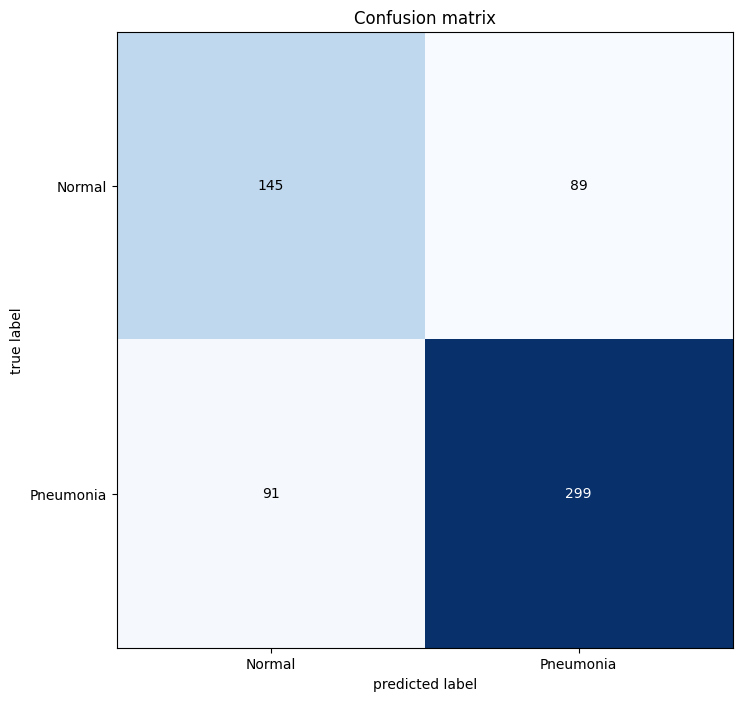

In [28]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()